In [2]:
# import math lib
from math import pi

# import Qiskit
from qiskit import Aer, execute
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister

# import basic plot tools
from qiskit.tools.visualization import plot_histogram
# To use local qasm simulator
backend = Aer.get_backend('qasm_simulator')

In [3]:
# %load functions


def show_results(D):
    # D is a dictionary with classical bits as keys and count as value
    # example: D = {'000': 497, '001': 527}
    plt.bar(range(len(D)), list(D.values()), align='center')
    plt.xticks(range(len(D)), list(D.keys()))
    plt.show()

# Execute circuit, display a histogram of the results
def execute_locally(qc, draw_circuit=False):
    # Compile and run the Quantum circuit on a simulator backend
    backend_sim = Aer.get_backend('qasm_simulator')
    job_sim = execute(qc, backend_sim, shots=1000)
    result_sim = job_sim.result()
    result_counts = result_sim.get_counts(qc)
    
    # Print the results
    print("simulation: \n\n", result_counts)
    show_results(result_counts)

def qftransform (circuit, qr, swap = True, n=0):
    if n == 0:
        n=qr.size
    for i in range(n-1, -1, -1):
        circuit.barrier()
        circuit.h(qr[i])
        for j in range (i-1, -1, -1):
            r = 2**(i-j+1)
            circuit.cu1((2*pi/r), qr[j], qr[i])
    circuit.barrier()
    if swap == True and n > 1:
        for i in range(0, n//2):
            circuit.swap(qr[i], qr[n-i-1])
            
def inverse_qftransform (circuit, qr, swap = True, n=0):
    if n == 0:
        n=qr.size
    if swap == True and n > 1:
        for i in range(0, n//2):
            circuit.swap(qr[i], qr[n-i-1])
    for i in range(0, n, 1):
        circuit.barrier()
        for j in range (0, i, 1):
            r = 2**(i-j+1)
            circuit.cu1((-2*pi/r), qr[i], qr[j])
        circuit.h(qr[i])
    circuit.barrier()

def phase_est(qc, qr,qin, theta, phi, lamb, n):
    teta= -(1/2)*1*(2*pi)/(2**n)
    
    
    
    for i in range(n):
        qc.h(qr[i])
        for j in range(2**i):
            qc.cu3(teta,-pi/2,pi/2,qr[i],qin[0])
            
    inverse_qftransform(qc,qr,n=n)

def inv_phase_est(qc,qr,qin,theta,phi,lamb,n):
    A = [[1.5,0.5],[0.5,1.5]]
    k = 2
    t0 = 2*pi
    T = 2**n
    teta= A[0][1] * k * t0 / T
    qftransform(qc,qr,n=n)
    for k in range(n):
        for j in range(2**k):
            qc.cu3(teta,-pi/2,pi/2,qr[k],qin[0])
        
    for i in range(n):
        qc.h(qr[i])
    

In [5]:
# create Quantum Register called "qr" with 4 qubits
qr = QuantumRegister(4, name="qr")
# create Quantum Register called "cr" with 4 qubits
cr = ClassicalRegister(4, name="cr")
# Creating Quantum Circuit called "qc" involving your Quantum Register "qr"
# and your Classical Register "cr"
qc = QuantumCircuit(qr, cr, name="solve_linear_sys")        
    
# Initialize times that we get the result vector 
n0 = 0
n1 = 0
A=[[1.5,0.5],[0.5,1.5]]
kk = 2    #hamiltonian evolution number k
t0 = 2*pi   #hamiltonian evolution number t0
T = 2**n 
theta= A[0][1] * kk * t0 / T


for i in range(1):
    #Set the input|b> state"
    qc.x(qr[2])
        
    #Set the phase estimation circuit
    qc.h(qr[0])
    qc.h(qr[1]) 
    qc.u1(pi, qr[0])
    qc.u1(pi/2, qr[1])
    qc.cx(qr[1], qr[2])
    
    #The quantum inverse  Fourier transform 
    qc.h(qr[0])
    qc.cu1(-pi/2, qr[0], qr[1])
    qc.h(qr[1])
    
    #R（lamda^-1） Rotation
    qc.x(qr[1])
    qc.cu3(pi/16, 0, 0, qr[0], qr[3])
    qc.cu3(pi/8, 0, 0, qr[1], qr[3])   
    
    #Uncomputation
    qc.x(qr[1])
    qc.h(qr[1])
    qc.cu1(pi/2, qr[0], qr[1])
    qc.h(qr[0])
    
    qc.cx(qr[1], qr[2])
    qc.u1(-pi/2, qr[1])
    qc.u1(-pi, qr[0])
    
    qc.h(qr[1]) 
    qc.h(qr[0])
         
    # To measure the whole quantum register
    qc.measure(qr[0], cr[0])
    qc.measure(qr[1], cr[1])
    qc.measure(qr[2], cr[2])
    qc.measure(qr[3], cr[3])

    job_sim = execute(qc, backend=backend, shots=8192,)
    #result = job.result()
    result_sim = job_sim.result()
    result_counts = result_sim.get_counts(qc)
        
    # Get the sum og all results
   # n0 = n0 + result_sim.get_data("solve_linear_sys")['counts']['1000']
    #n1 = n1 + result_sim.get_data("solve_linear_sys")['counts']['1100']
    
    # print the result
    #print(result)
#     print(result.get_data(qc))
    plot_histogram(result_counts)
        
                
#     Reset the circuit
    qc.reset(qr)
    
    # calculate the scale of the elements in result vectot and print it.
  #  p = n0/n1
   # print(n0)
   # print(n1)
  #  print(p)

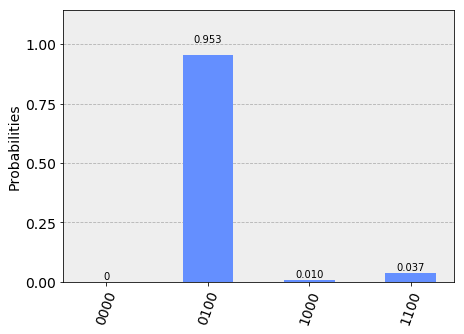

In [6]:
plot_histogram(result_counts)

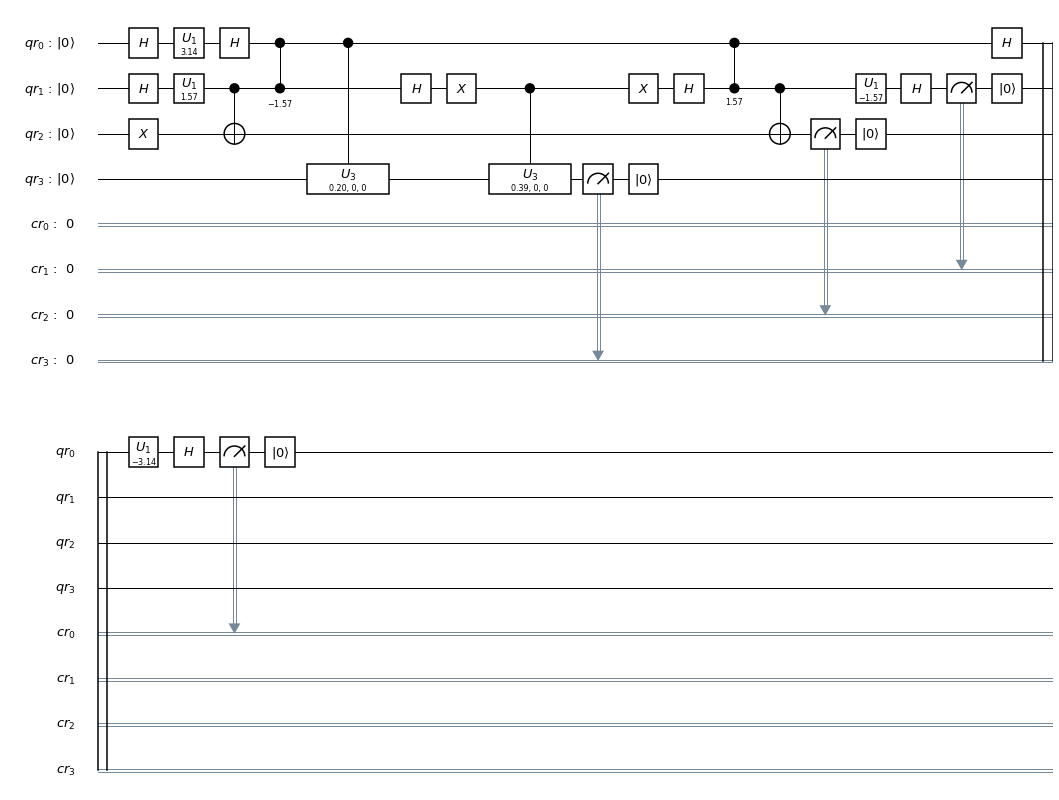

In [7]:
qc.draw(output='mpl')
